In [16]:
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
# NEW (GPU): choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [18]:
# Load CSV
df = pd.read_csv("Tweets.csv")

In [19]:
# Keep only text + sentiment
df = df[['text', 'airline_sentiment']]

# NEW: basic cleaning
df = df.dropna(subset=['text', 'airline_sentiment'])          # remove missing rows
df = df.drop_duplicates(subset=['text', 'airline_sentiment']) # remove exact duplicates

In [20]:
# Encode labels
label_map = {"negative":0, "neutral":1, "positive":2}
df['label'] = df['airline_sentiment'].map(label_map)

In [21]:
# Convert to HF Dataset
dataset = Dataset.from_pandas(df[['text','label']])

In [22]:
# Train-test split
dataset = dataset.train_test_split(test_size=0.2, seed=42)

In [23]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [24]:
# Tokenize function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=128)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])


Map:   0%|          | 0/11561 [00:00<?, ? examples/s]

Map:   0%|          | 0/2891 [00:00<?, ? examples/s]

In [25]:
# Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [26]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [27]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert_sentiment",
    eval_steps=500,              # evaluate every 500 steps instead of "evaluation_strategy"
    save_steps=500,              # save every 500 steps instead of "save_strategy"
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,

    fp16=torch.cuda.is_available(),
)

In [28]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    compute_metrics=compute_metrics
)

In [29]:
# Train BERT
trainer.train()

Step,Training Loss
100,0.706000
200,0.490900
300,0.479600
400,0.436700
500,0.437300
600,0.451800
700,0.424200
800,0.288800
900,0.302000
1000,0.324700


TrainOutput(global_step=2169, training_loss=0.32333335111414907, metrics={'train_runtime': 257.733, 'train_samples_per_second': 134.569, 'train_steps_per_second': 8.416, 'total_flos': 2281390666765056.0, 'train_loss': 0.32333335111414907, 'epoch': 3.0})

=== BERT Classification Report ===
              precision    recall  f1-score   support

    negative       0.90      0.92      0.91      1795
     neutral       0.71      0.67      0.69       629
    positive       0.80      0.79      0.79       467

    accuracy                           0.84      2891
   macro avg       0.80      0.79      0.80      2891
weighted avg       0.84      0.84      0.84      2891



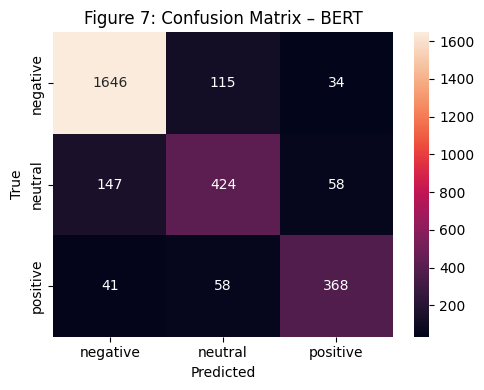

=== BERT Eval Metrics (Trainer) ===
{'eval_loss': 0.5520042181015015, 'eval_accuracy': 0.8433068142511242, 'eval_precision': 0.8409978509682196, 'eval_recall': 0.8433068142511242, 'eval_f1': 0.8419773677385703, 'eval_runtime': 5.3087, 'eval_samples_per_second': 544.577, 'eval_steps_per_second': 34.095, 'epoch': 3.0}


In [30]:
# Evaluate
labels = ['negative', 'neutral', 'positive']

# Get predictions on the test set
pred_output = trainer.predict(dataset['test'])
y_true = pred_output.label_ids
y_pred = np.argmax(pred_output.predictions, axis=1)

# 1) Print a nice classification report
print("=== BERT Classification Report ===")
print(classification_report(y_true, y_pred, target_names=labels))

# 2) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Figure 7: Confusion Matrix – BERT")
plt.tight_layout()
plt.show()

# 3) Also show the Trainer metrics dict (accuracy, precision, recall, f1)
results = trainer.evaluate()
print("=== BERT Eval Metrics (Trainer) ===")
print(results)